In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

def get_sorted_file_paths(directory):
    # Get a list of all files in the directory
    files = os.listdir(directory)

    # Filter out non-image files (you can customize this if needed)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Create full file paths by joining directory path and file names
    file_paths = [os.path.join(directory, filename) for filename in image_files]

    # Sort the file paths
    sorted_file_paths = sorted(file_paths)

    return sorted_file_paths

# Replace 'path/to/images' with the path to your images directory
directory_path = '/content/drive/MyDrive/Datasets/UP-3D/images'
sorted_image_files = get_sorted_file_paths(directory_path)

# Print the sorted file paths
#for path in sorted_image_files:
#    print(path)


In [4]:
import os

def get_sorted_file_paths(directory):
    # Get a list of all files in the directory
    files = os.listdir(directory)

    # Filter out non-image files (you can customize this if needed)
    mask_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Create full file paths by joining directory path and file names
    file_paths = [os.path.join(directory, filename) for filename in mask_files]

    # Sort the file paths
    sorted_file_paths = sorted(file_paths)

    return sorted_file_paths

# Replace 'path/to/images' with the path to your images directory
directory_path = '/content/drive/MyDrive/Datasets/UP-3D/masks'
sorted_mask_files = get_sorted_file_paths(directory_path)

# Print the sorted file paths
#for path in sorted_mask_files:
#    print(path)


In [5]:
# Filter the file paths to exclude those containing "(1)"
sorted_mask_files = [file_path for file_path in sorted_mask_files if "(1)" not in file_path]


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from natsort import natsorted
from pathlib import Path

# **Load** **data**

In [7]:
# create a list to store images
images = []
# iterate over 1000 image paths
for path in tqdm(sorted_image_files):
    # read file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    # append to the list
    images.append(image)


# create a list to store masks
masks = []
# iterate over 1000 mask paths
for path in tqdm(sorted_mask_files):
    # read the file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    # append mask to the list
    masks.append(mask)

100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


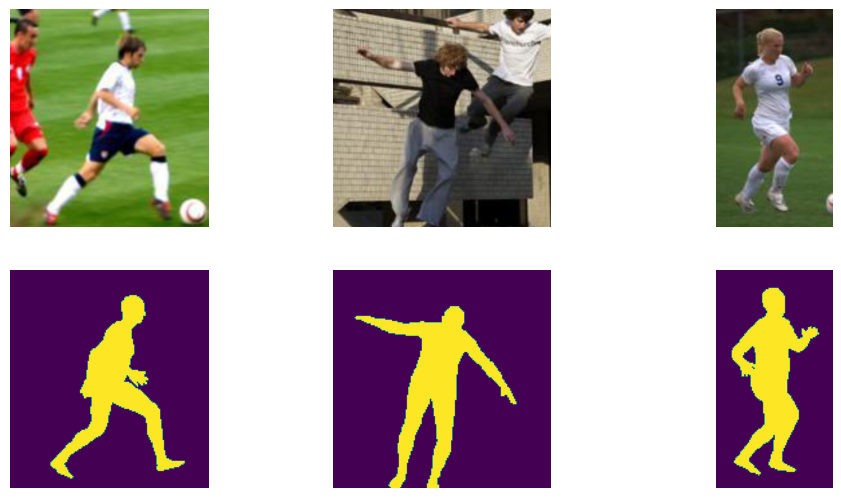

In [8]:

# Plot images and masks side by side
plt.figure(figsize=(25, 13))

for i in range(4, 7):
    # Plot image
    plt.subplot(4, 6, i - 2)
    img = images[i]
    plt.imshow(img)
    plt.axis('off')

    # Plot mask
    plt.subplot(4, 6, i + 4)  # Adjust the subplot index for masks
    mask = tf.keras.utils.img_to_array(masks[i])
    mask = tf.cast((mask > 0), tf.float32)
    plt.imshow(mask)
    plt.axis('off')

plt.show()


## **Preprocessing**

In [9]:
# Resizing the images and mask to 128 x 128

def resize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask


X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)


(1000, 1000)

# **Model Developement**

In [10]:
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2,
                                                      random_state=0
                                                     )
# develop tf Dataset objects
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [11]:
#zip images and masks
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

In [12]:
#setting the batch size
BATCH = 64

AT = tf.data.AUTOTUNE
#buffersize
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [13]:
# Use pre-trained DenseNet121 without head
base = keras.applications.DenseNet121(input_shape=[128,128,3],
                                      include_top=False,
                                      weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [14]:
#final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [15]:
# Building Downstack

#output of these layers
skip_outputs = [base.get_layer(name).output for name in skip_names]
#Building the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

In [16]:
# Building Upstack

!pip install -q git+https://github.com/tensorflow/examples.git --quiet


from tensorflow_examples.models.pix2pix import pix2pix

# Four upstack layers for upsampling sizes
# 4->8, 8->16, 16->32, 32->64
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

  Preparing metadata (setup.py) ... done


In [17]:

# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(59, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

In [18]:
# compiling the model
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])
Compile_Model()

In [19]:
# training and fine-tuning
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=20,
               verbose=2)

Epoch 1/20
12/12 - 28s - loss: 3.0540 - accuracy: 0.5742 - val_loss: 3.5806 - val_accuracy: 0.7330 - 28s/epoch - 2s/step
Epoch 2/20
12/12 - 10s - loss: 1.8735 - accuracy: 0.7367 - val_loss: 3.2637 - val_accuracy: 0.7121 - 10s/epoch - 871ms/step
Epoch 3/20
12/12 - 4s - loss: 1.4584 - accuracy: 0.7475 - val_loss: 2.8429 - val_accuracy: 0.7313 - 4s/epoch - 320ms/step
Epoch 4/20
12/12 - 4s - loss: 1.2549 - accuracy: 0.7509 - val_loss: 2.3373 - val_accuracy: 0.7411 - 4s/epoch - 320ms/step
Epoch 5/20
12/12 - 4s - loss: 1.1266 - accuracy: 0.7545 - val_loss: 1.9144 - val_accuracy: 0.7419 - 4s/epoch - 315ms/step
Epoch 6/20
12/12 - 4s - loss: 1.0547 - accuracy: 0.7567 - val_loss: 1.8294 - val_accuracy: 0.7461 - 4s/epoch - 302ms/step
Epoch 7/20
12/12 - 4s - loss: 0.9923 - accuracy: 0.7611 - val_loss: 1.4359 - val_accuracy: 0.7361 - 4s/epoch - 305ms/step
Epoch 8/20
12/12 - 4s - loss: 0.9269 - accuracy: 0.7686 - val_loss: 1.3478 - val_accuracy: 0.7510 - 4s/epoch - 311ms/step
Epoch 9/20
12/12 - 4s -

2/2 [==============================] - 7s 98ms/step


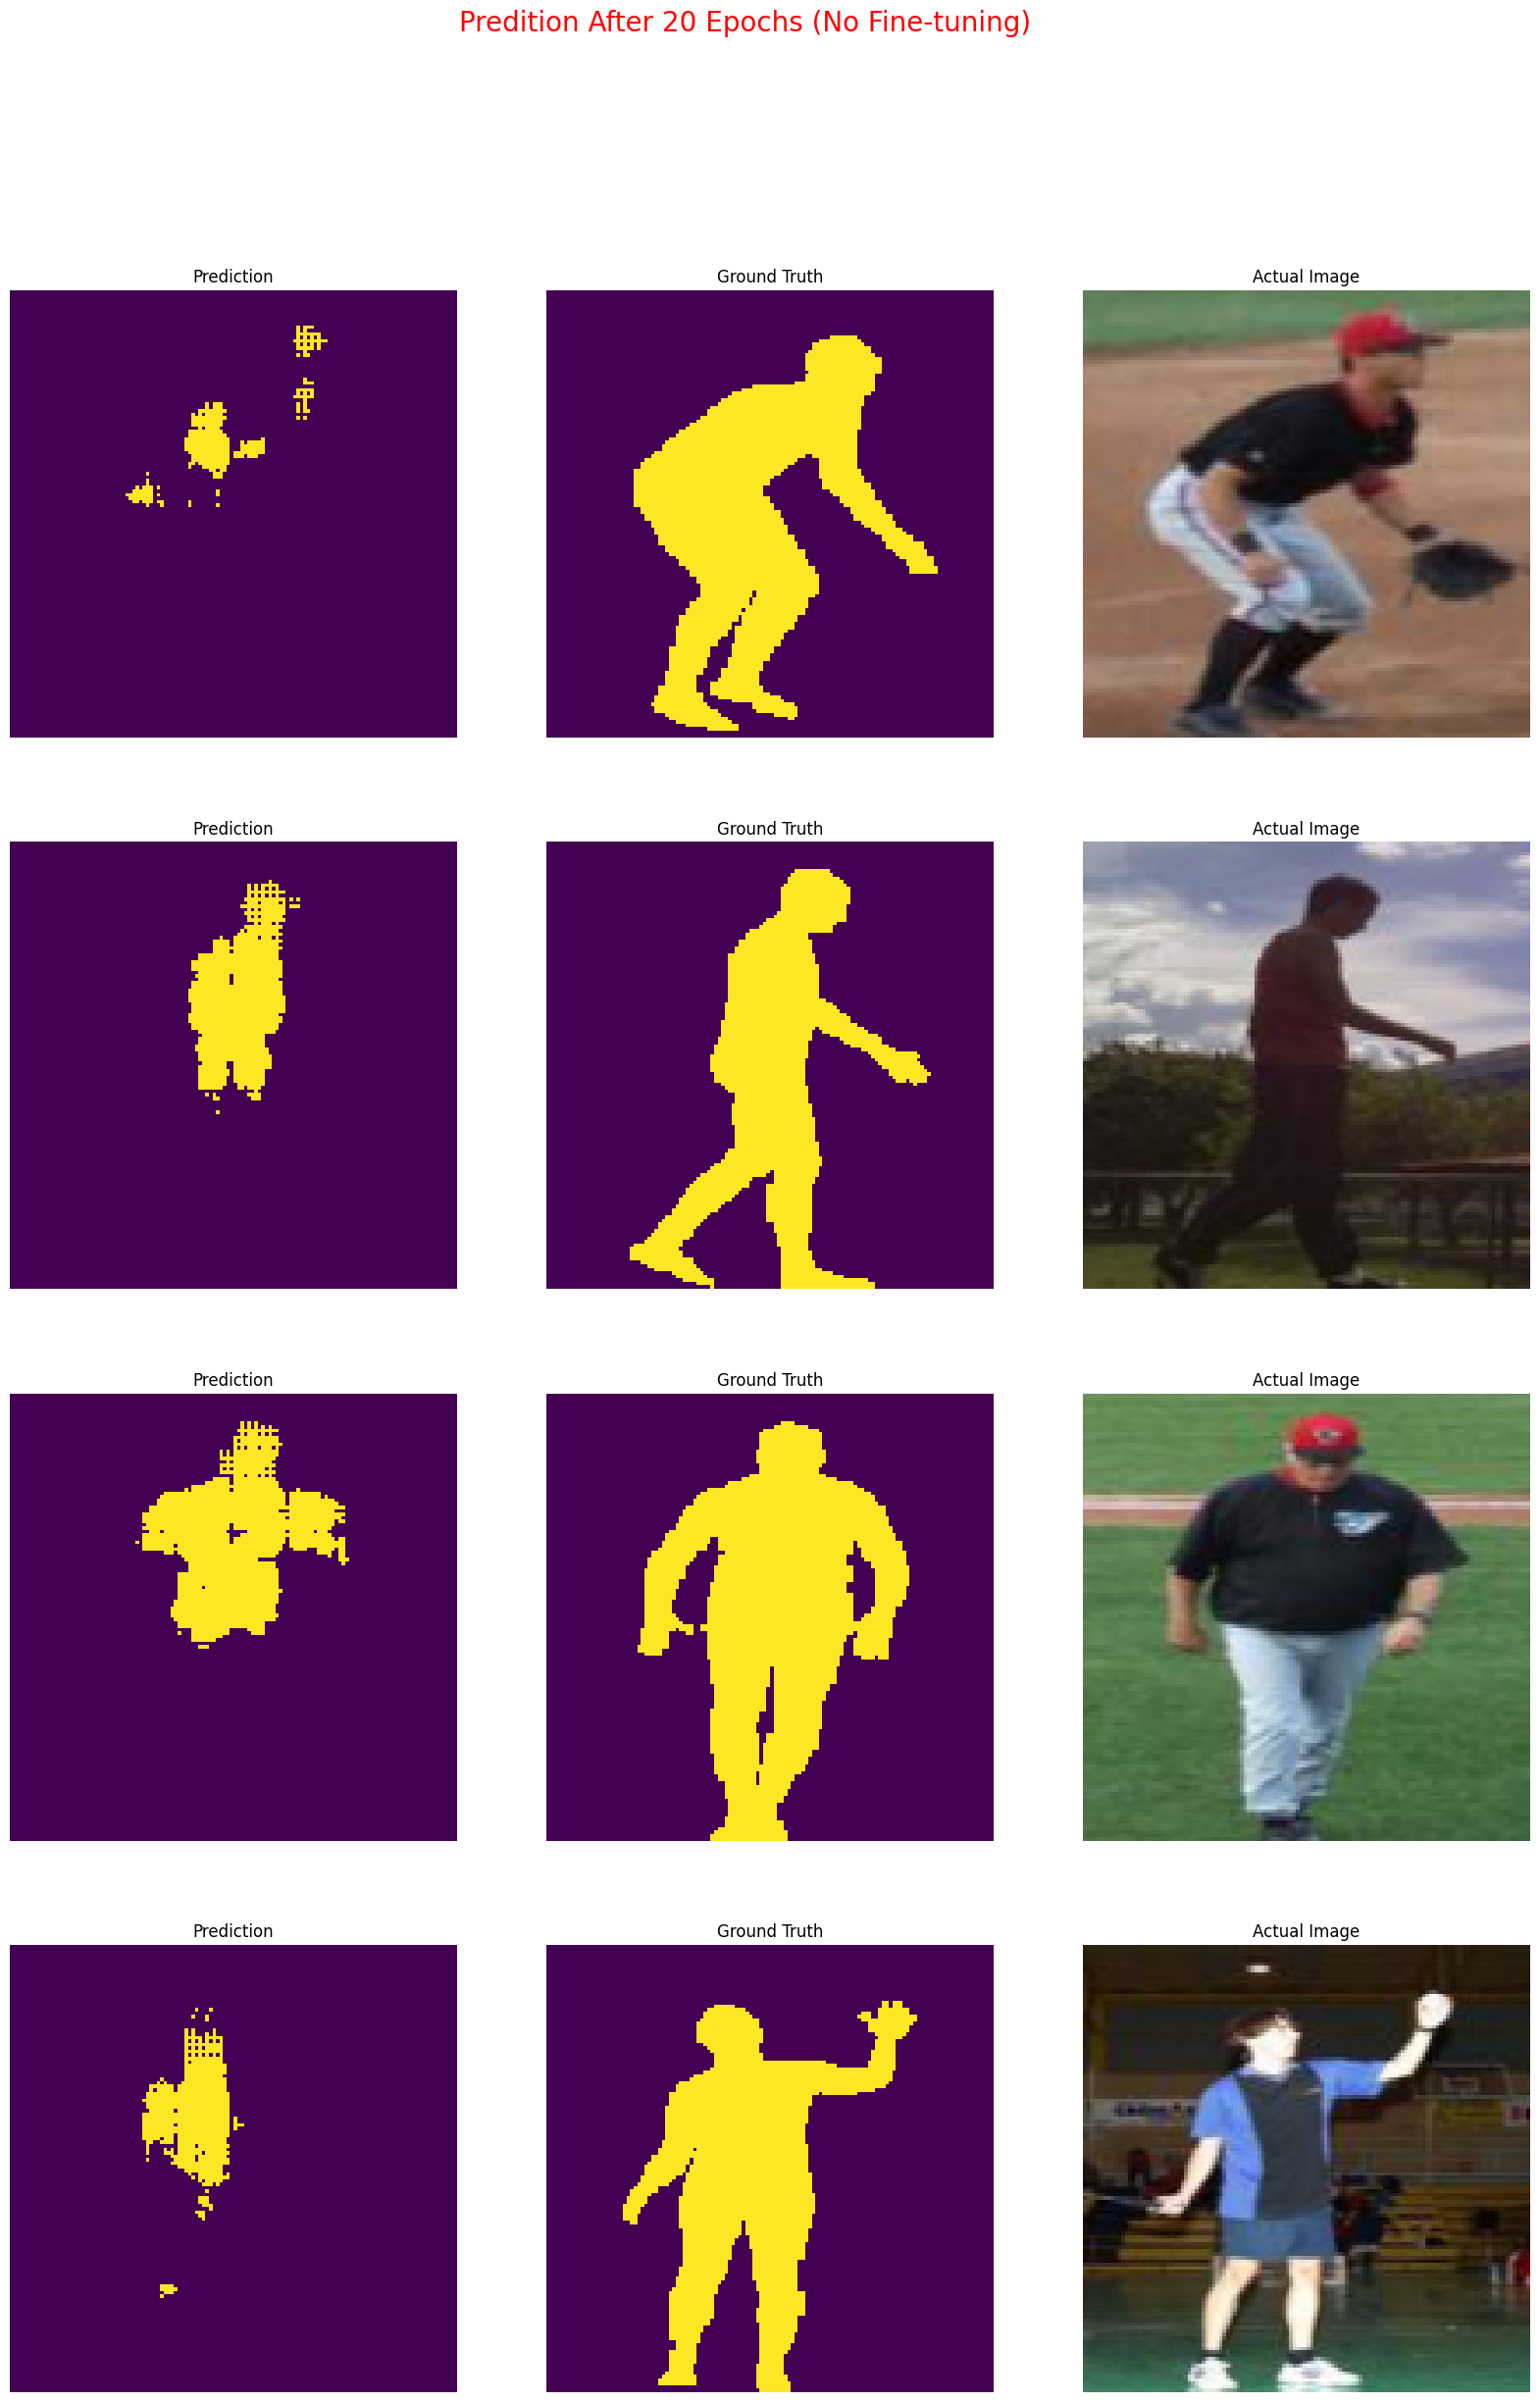

In [20]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    img1 = tf.keras.utils.img_to_array(i)
    mask1 = tf.cast((img1>0), tf.float32)
    plt.imshow(mask1)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    img2 = tf.keras.utils.img_to_array(mask[k])
    mask2 = tf.cast((img2>0), tf.float32)
    plt.imshow(mask2)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 20 Epochs (No Fine-tuning)', color='red', size=20)
plt.show()

In [21]:
downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 20 to 40
hist_2 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=40, initial_epoch = 20,
               verbose = 2
                 )

Epoch 21/40
12/12 - 59s - loss: 0.7991 - accuracy: 0.7760 - val_loss: 0.7477 - val_accuracy: 0.7742 - 59s/epoch - 5s/step
Epoch 22/40
12/12 - 9s - loss: 0.6364 - accuracy: 0.8027 - val_loss: 0.7672 - val_accuracy: 0.7784 - 9s/epoch - 791ms/step
Epoch 23/40
12/12 - 6s - loss: 0.5980 - accuracy: 0.8112 - val_loss: 0.7702 - val_accuracy: 0.7851 - 6s/epoch - 464ms/step
Epoch 24/40
12/12 - 6s - loss: 0.5814 - accuracy: 0.8172 - val_loss: 0.8037 - val_accuracy: 0.7772 - 6s/epoch - 461ms/step
Epoch 25/40
12/12 - 6s - loss: 0.5457 - accuracy: 0.8278 - val_loss: 0.8634 - val_accuracy: 0.7778 - 6s/epoch - 463ms/step
Epoch 26/40
12/12 - 5s - loss: 0.5141 - accuracy: 0.8422 - val_loss: 0.9200 - val_accuracy: 0.7754 - 5s/epoch - 455ms/step
Epoch 27/40
12/12 - 5s - loss: 0.5164 - accuracy: 0.8430 - val_loss: 0.8010 - val_accuracy: 0.7949 - 5s/epoch - 451ms/step
Epoch 28/40
12/12 - 5s - loss: 0.4631 - accuracy: 0.8637 - val_loss: 0.8186 - val_accuracy: 0.7876 - 5s/epoch - 455ms/step
Epoch 29/40
12/12

2/2 [==============================] - 3s 102ms/step


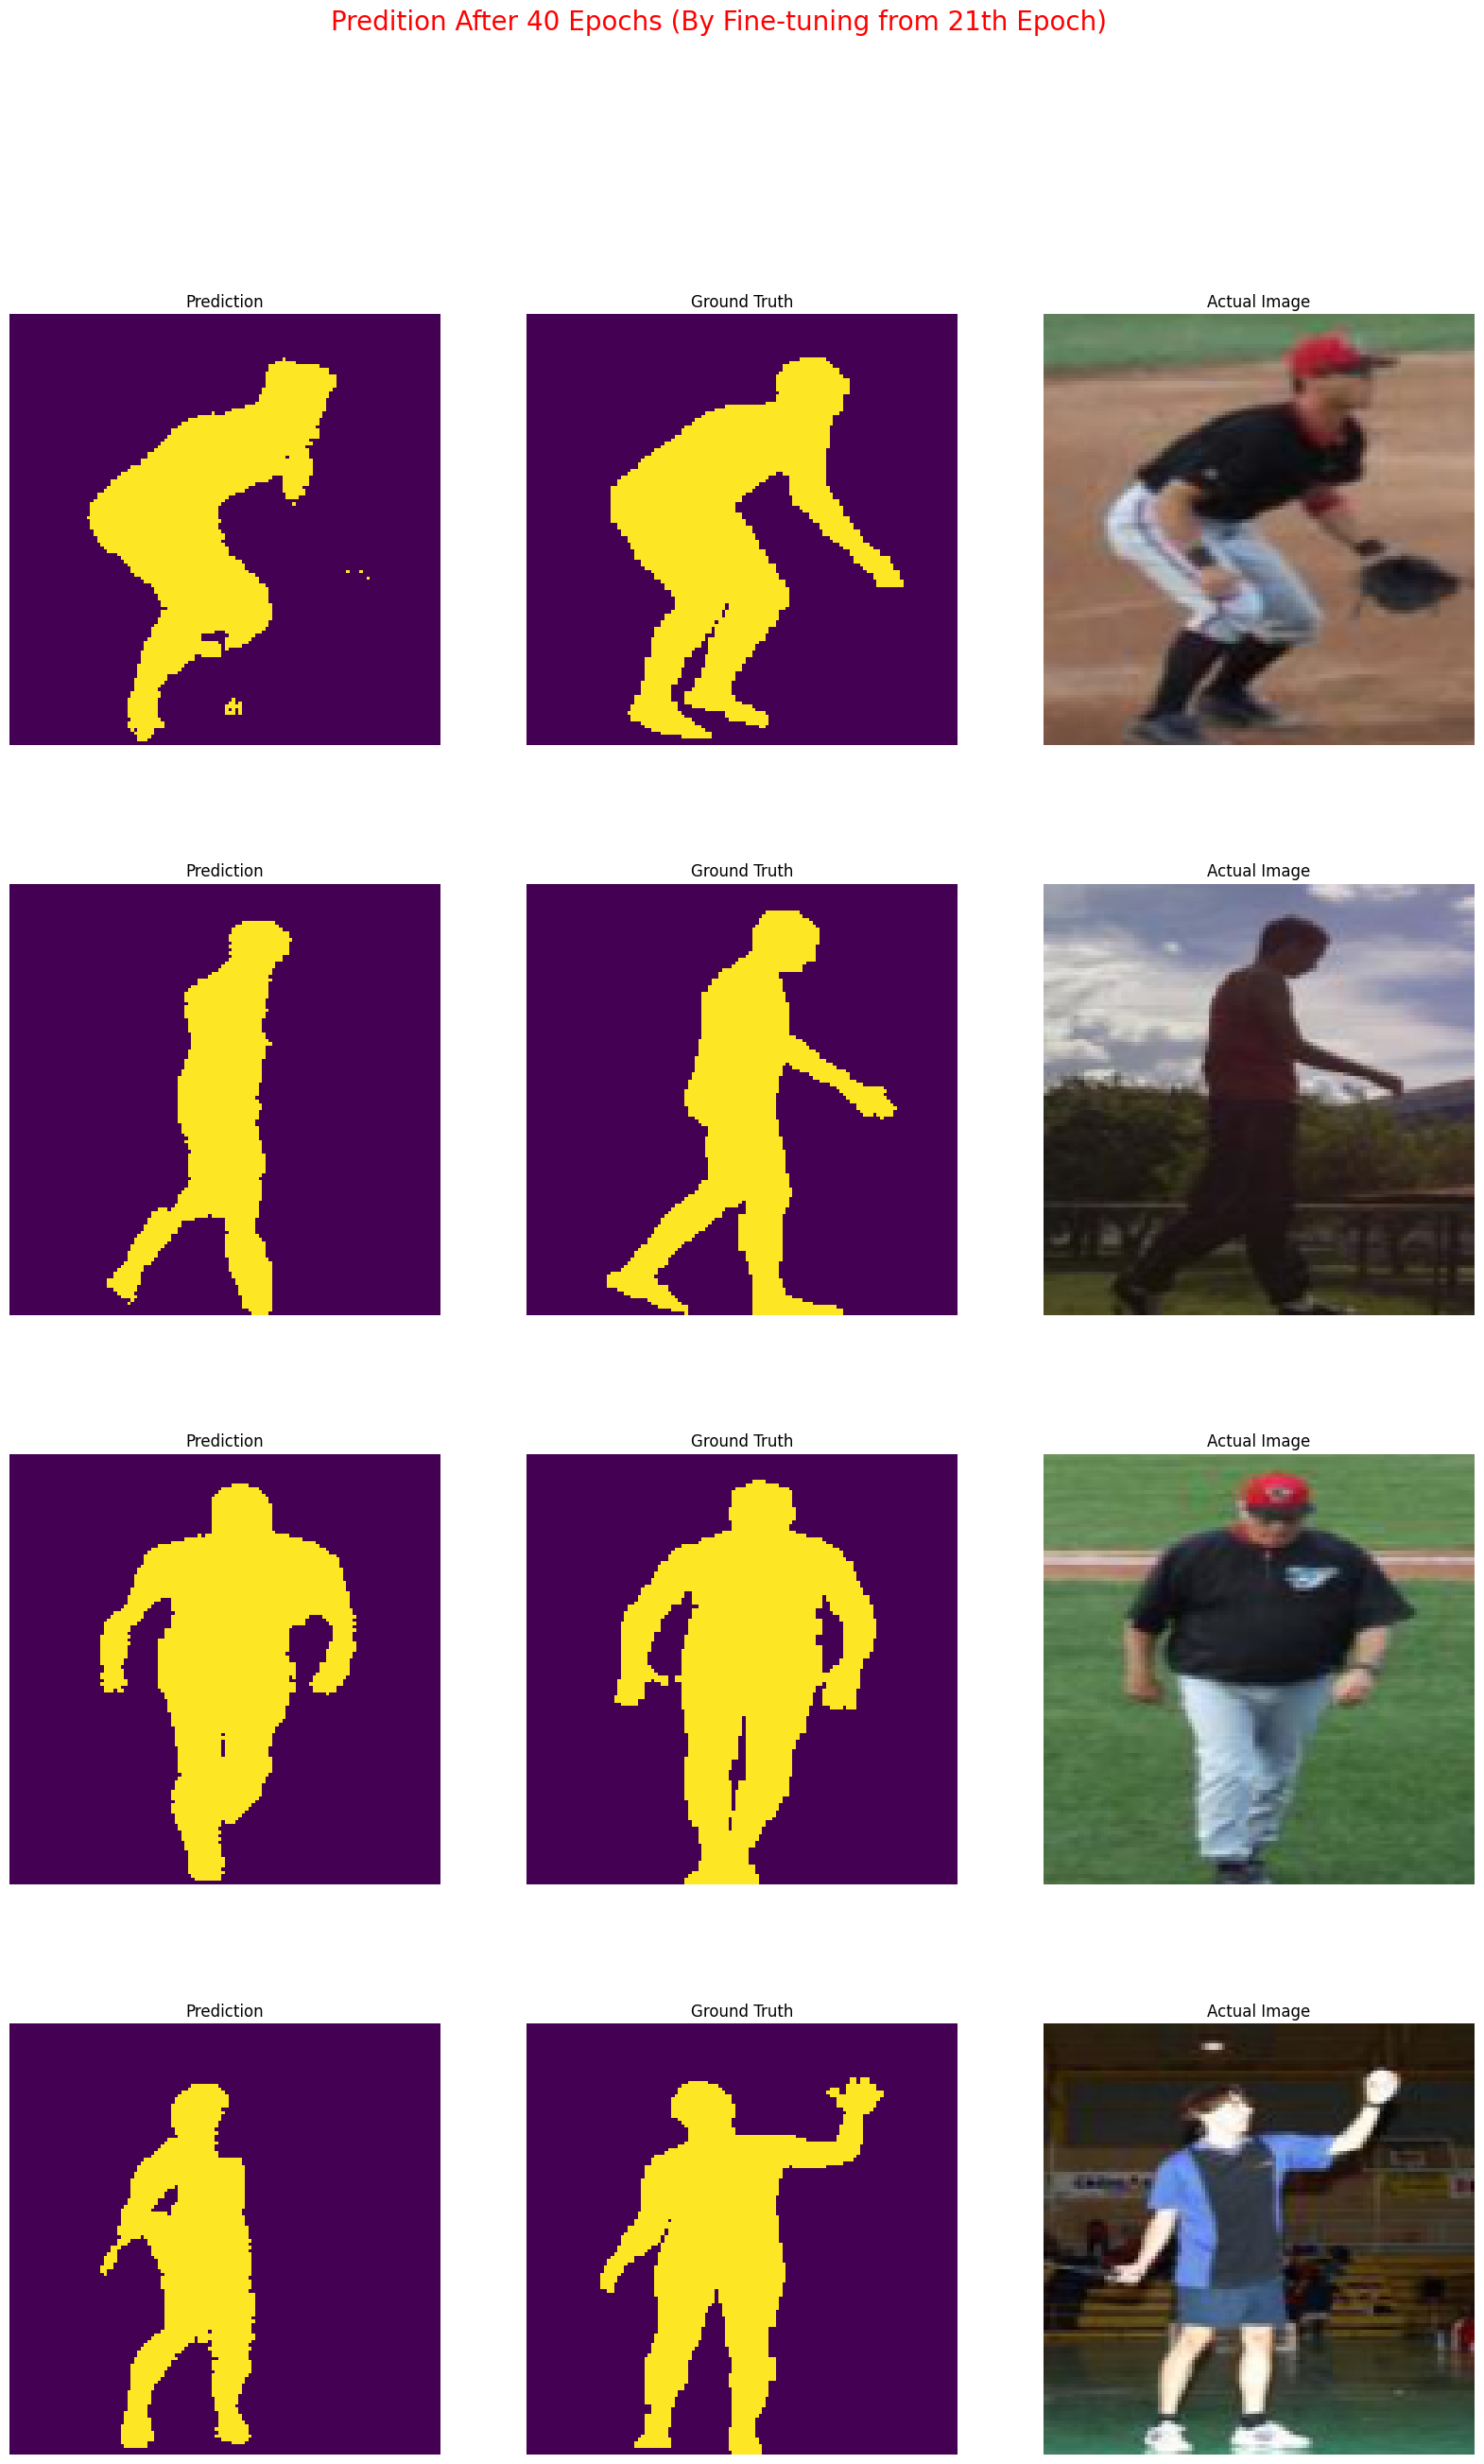

In [22]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    img1 = tf.keras.utils.img_to_array(i)
    mask1 = tf.cast((img1>0), tf.float32)
    plt.imshow(mask1)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    img2 = tf.keras.utils.img_to_array(mask[k])
    mask2 = tf.cast((img2>0), tf.float32)
    plt.imshow(mask2)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 40 Epochs (By Fine-tuning from 21th Epoch)', color='red', size=20)
plt.show()